# SubQuestion: What period of time throughout the year have the highest mortality rates for ICU patients and are there any factors that influence that? 

In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency
import numpy as np

In [2]:
# Load the datasets
admissions = pd.read_csv('mimic-iii-clinical-database-1.4/ADMISSIONS.csv.gz')
patients = pd.read_csv('mimic-iii-clinical-database-1.4/PATIENTS.csv.gz')
icustays = pd.read_csv('mimic-iii-clinical-database-1.4/ICUSTAYS.csv.gz')

In [21]:
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,RENAL CANCER/SDA,0,1
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0


In [22]:
icustays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202
...,...,...,...,...,...,...,...,...,...,...,...,...
61527,59806,94944,143774,201233,metavision,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,2.1894
61528,59807,94950,123750,283653,metavision,CCU,CCU,7,7,2155-12-08 05:33:16,2155-12-10 17:24:58,2.4942
61529,59808,94953,196881,241585,metavision,SICU,SICU,57,57,2160-03-03 16:09:11,2160-03-04 14:22:33,0.9259
61530,59809,94954,118475,202802,metavision,CSRU,CSRU,15,15,2183-03-25 09:53:10,2183-03-27 17:55:03,2.3346


In [3]:
# Convert date columns to datetime
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
patients['DOB'] = pd.to_datetime(patients['DOB'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

# Fill or drop missing values based on the analysis requirement
# admissions.dropna(subset=['DEATHTIME'], inplace=True) # focusing on mortality

In [4]:
# Merging the tables
df = admissions.merge(patients, on='SUBJECT_ID')
df = df.merge(icustays, on=['SUBJECT_ID', 'HADM_ID'])

In [5]:
df['ADMIT_MONTH'] = df['ADMITTIME'].dt.month
df['AGE'] = df['ADMITTIME'].dt.year - df['DOB'].dt.year
df['ICU_LOS'] = (df['OUTTIME'] - df['INTIME']).dt.total_seconds() / 86400  # Length of Stay in days
df['ICU_IN_MONTH'] = df['INTIME'].dt.month

# Dropping rows with any NA values in the specific columns of interest
df = df.dropna(subset=['ADMIT_MONTH', 'AGE', 'ICU_LOS', 'ICU_IN_MONTH'])

In [23]:
df

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,ADMIT_MONTH,AGE,ICU_LOS,MORTALITY_FLAG
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,MICU,52,52,2196-04-09 12:27:00,2196-04-10 15:54:00,1.1438,4,65,1.143750,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CSRU,14,14,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641,9,71,1.264074,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,SICU,57,57,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862,10,75,1.186227,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,CCU,7,7,2139-06-06 16:15:36,2139-06-07 04:33:25,0.5124,6,39,0.512373,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,CCU,7,7,2160-11-02 03:16:23,2160-11-05 16:23:27,3.5466,11,59,3.546574,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,CSRU,15,15,2127-11-07 10:02:54,2127-11-09 16:58:46,2.2888,11,78,2.288796,0
61528,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,MICU,50,50,2132-12-24 20:08:16,2132-12-26 01:51:14,1.2382,12,88,1.238171,1
61529,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,TSICU,14,14,2131-03-30 21:14:14,2131-03-31 18:18:14,0.8778,3,20,0.877778,0
61530,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,MICU,50,50,2151-03-05 20:01:18,2151-03-06 10:54:24,0.6202,3,84,0.620208,1


In [6]:
nan_count = df.isna().sum()
print(nan_count)
df.shape

ROW_ID_x                    0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               54914
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                26144
RELIGION                  480
MARITAL_STATUS          10233
ETHNICITY                   0
EDREGTIME               28751
EDOUTTIME               28751
DIAGNOSIS                   1
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
ROW_ID_y                    0
GENDER                      0
DOB                         0
DOD                     37333
DOD_HOSP                45309
DOD_SSN                 41071
EXPIRE_FLAG                 0
ROW_ID                      0
ICUSTAY_ID                  0
DBSOURCE                    0
FIRST_CAREUNIT              0
LAST_CAREUNIT               0
FIRST_WARDID                0
LAST_WARDID                 0
INTIME    

(61522, 39)

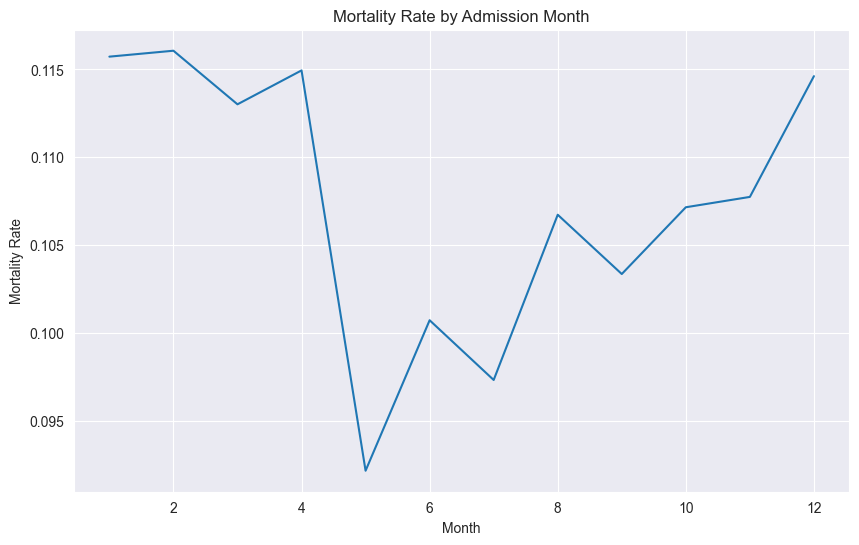

In [7]:
# Ensure 'DEATHTIME' is in datetime format for any operations that might require it
df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME'], errors='coerce')

# # Creating a mortality flag (1 if DEATHTIME is not null, 0 otherwise)
# df['MORTALITY_FLAG'] = df['DEATHTIME'].notnull().astype(int)

# Calculating mortality rates by month correctly
mortality_by_month = df.groupby('ADMIT_MONTH')['EXPIRE_FLAG'].agg(['mean']).reset_index()
mortality_by_month.rename(columns={'mean': 'mortality_rate'}, inplace=True)

# Plotting corrected mortality rates by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=mortality_by_month, x='ADMIT_MONTH', y='mortality_rate')
plt.title('Mortality Rate by Admission Month')
plt.xlabel('Month')
plt.ylabel('Mortality Rate')
plt.show()


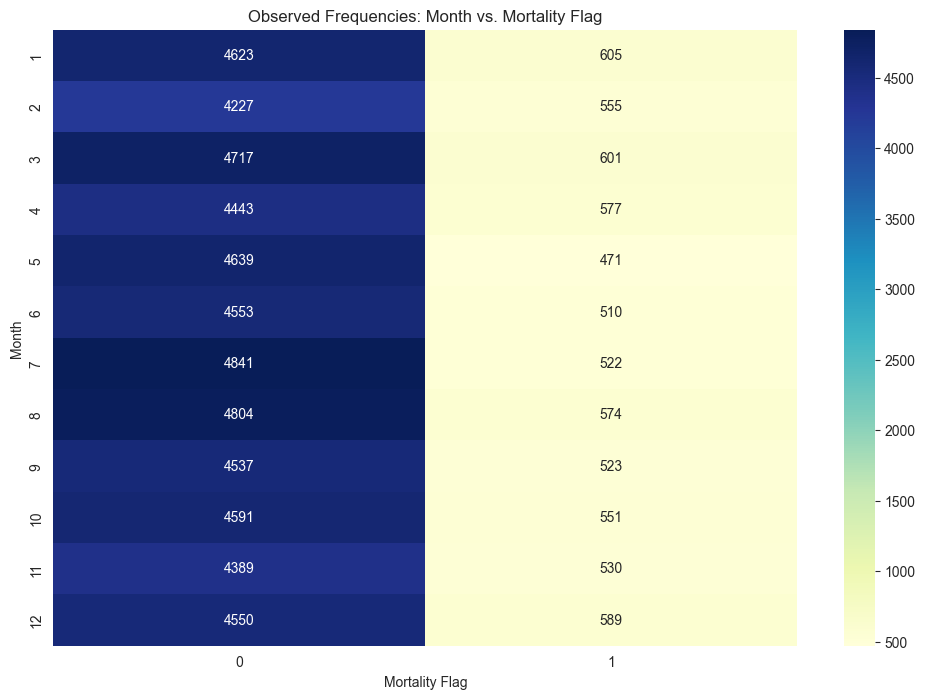

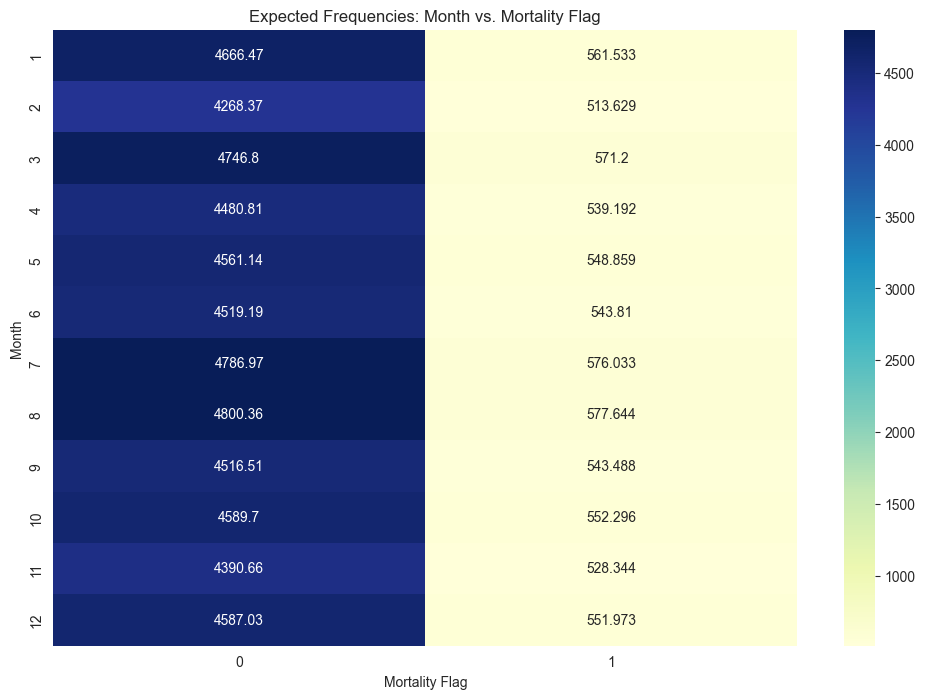

Chi-Square Test Statistic: 36.304876139986746
P-value: 0.00015056984719057475


In [13]:
# Chi-Square Test for Independence for categorical month and mortality flag

# Contingency table of month and mortality flag
contingency_table = pd.crosstab(df['ADMIT_MONTH'], df['EXPIRE_FLAG'])

# Performing the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Plotting the observed frequencies
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Observed Frequencies: Month vs. Mortality Flag')
plt.ylabel('Month')
plt.xlabel('Mortality Flag')
plt.show()

# Plotting the expected frequencies
plt.figure(figsize=(12, 8))
sns.heatmap(expected, annot=True, cmap="YlGnBu", fmt='g', 
            xticklabels=contingency_table.columns, yticklabels=contingency_table.index)
plt.title('Expected Frequencies: Month vs. Mortality Flag')
plt.ylabel('Month')
plt.xlabel('Mortality Flag')
plt.show()

# Print the Chi-Square Test results
print(f"Chi-Square Test Statistic: {chi2}")
print(f"P-value: {p}")

Optimization terminated successfully.
         Current function value: 0.331102
         Iterations 6
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10961
           1       0.00      0.00      0.00      1344

    accuracy                           0.89     12305
   macro avg       0.45      0.50      0.47     12305
weighted avg       0.79      0.89      0.84     12305

AUC: 0.6784928898345215


/Users/ninad/Projects/pythonProject1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ninad/Projects/pythonProject1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ninad/Projects/pythonProject1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

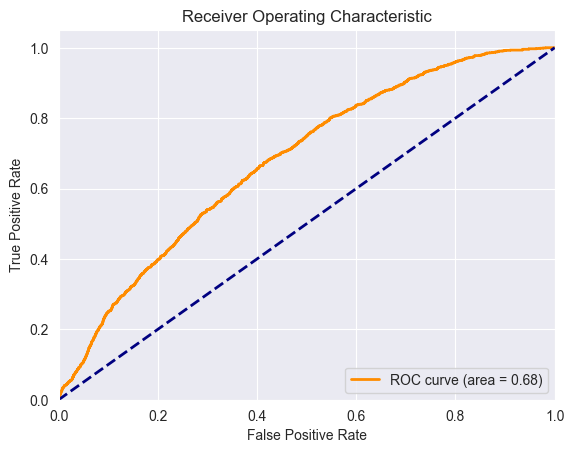

In [15]:
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split

# Preparing data for logistic regression (adding a constant term for the intercept)
X = df[['ADMIT_MONTH', 'AGE', 'ICU_LOS']]
X = sm.add_constant(X)  # adding a constant
y = df['EXPIRE_FLAG']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and fitting the logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Predicting the probabilities on the test set
y_pred_probs = result.predict(X_test)

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Print the classification report
print(classification_report(y_test, result.predict(X_test) > 0.5))

# Print the AUC
print("AUC:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
# # Preparing data for logistic regression
# X = df[['ADMIT_MONTH', 'AGE', 'ICU_LOS']]
# y = df['MORTALITY_FLAG']
# 
# # Splitting the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 
# # Creating and fitting the logistic regression model
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train, y_train)
# 
# # Predicting and evaluating the model
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))
# 
# # If you're curious about the model's coefficients
# print("Model coefficients:", model.coef_)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10961
           1       0.00      0.00      0.00      1344

    accuracy                           0.89     12305
   macro avg       0.45      0.50      0.47     12305
weighted avg       0.79      0.89      0.84     12305

Model coefficients: [[-0.00512581  0.00597394  0.01424098]]


/Users/ninad/Projects/pythonProject1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ninad/Projects/pythonProject1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ninad/Projects/pythonProject1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [10]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import make_pipeline
# 
# # Preprocessing
# X = df[['ADMIT_MONTH', 'AGE', 'ICU_LOS']]
# y = df['MORTALITY_FLAG']
# 
# # Impute missing values as a part of the pipeline
# pipeline = make_pipeline(
#     SimpleImputer(strategy='median'), 
#     LogisticRegression(max_iter=1000)
# )
# 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 
# # Fit model
# pipeline.fit(X_train, y_train)
# 
# # Predict and evaluate
# y_pred = pipeline.predict(X_test)
# print(classification_report(y_test, y_pred))

--- 

In [26]:
# Assuming you have pandas DataFrames named icustays, admissions, and patients.
# Replace 'df_icustays', 'df_admissions', and 'df_patients' with your actual DataFrame names.

# First, check the columns to make sure 'SUBJECT_ID' and 'HADM_ID' exist
print(icustays.columns)
print(admissions.columns)
print(patients.columns)

# If the columns exist, you can do the merges
admissions_patients_merged = pd.merge(admissions, patients, on='SUBJECT_ID', how='inner')
complete_merged = pd.merge(admissions_patients_merged, icustays, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Now, each row of complete_merged represents a unique ICU stay with admission and patient information included.

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS'],
      dtype='object')
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')
Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')


In [27]:
complete_merged

,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,ROW_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,22,204798,carevue,MICU,MICU,52,52,2196-04-09 12:27:00,2196-04-10 15:54:00,1.1438
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,23,227807,carevue,CSRU,CSRU,14,14,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,24,234044,metavision,SICU,SICU,57,57,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,25,262236,carevue,CCU,CCU,7,7,2139-06-06 16:15:36,2139-06-07 04:33:25,0.5124
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,26,203487,carevue,CCU,CCU,7,7,2160-11-02 03:16:23,2160-11-05 16:23:27,3.5466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,58592,98794,190603,2127-11-07 11:00:00,2127-11-11 14:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,61127,262848,metavision,CSRU,CSRU,15,15,2127-11-07 10:02:54,2127-11-09 16:58:46,2.2888
61528,58593,98797,105447,2132-12-24 20:06:00,2132-12-25 12:00:00,2132-12-25 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,...,61128,244147,metavision,MICU,MICU,50,50,2132-12-24 20:08:16,2132-12-26 01:51:14,1.2382
61529,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,61129,210188,metavision,TSICU,TSICU,14,14,2131-03-30 21:14:14,2131-03-31 18:18:14,0.8778
61530,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,61130,294783,metavision,MICU,MICU,50,50,2151-03-05 20:01:18,2151-03-06 10:54:24,0.6202


In [28]:
nan_count = complete_merged.isna().sum()
print(nan_count)
df.shape

ROW_ID_x                    0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               54923
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                26154
RELIGION                  480
MARITAL_STATUS          10240
ETHNICITY                   0
EDREGTIME               28760
EDOUTTIME               28760
DIAGNOSIS                   1
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
ROW_ID_y                    0
GENDER                      0
DOB                         0
DOD                     37341
DOD_HOSP                45318
DOD_SSN                 41079
EXPIRE_FLAG                 0
ROW_ID                      0
ICUSTAY_ID                  0
DBSOURCE                    0
FIRST_CAREUNIT              0
LAST_CAREUNIT               0
FIRST_WARDID                0
LAST_WARDID                 0
INTIME    

(61522, 40)

In [137]:
transfers_df = pd.read_csv('mimic-iii-clinical-database-1.4/TRANSFERS.csv.gz', compression='gzip')
transfers_df = transfers_df.drop("ROW_ID", axis=1)

In [138]:
transfers_df.shape

(261897, 12)

In [139]:
transfers_df.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,INTIME,OUTTIME,LOS
0,111,192123,254245.0,carevue,transfer,CCU,MICU,7.0,23.0,2142-04-29 15:27:11,2142-05-04 20:38:33,125.19
1,111,192123,NaN,carevue,transfer,MICU,NaN,23.0,45.0,2142-05-04 20:38:33,2142-05-05 11:46:32,15.13
2,111,192123,NaN,carevue,discharge,NaN,NaN,45.0,NaN,2142-05-05 11:46:32,NaN,NaN
3,111,155897,249202.0,metavision,admit,NaN,MICU,NaN,52.0,2144-07-01 04:13:59,2144-07-01 05:19:39,1.09
4,111,155897,NaN,metavision,transfer,MICU,NaN,52.0,32.0,2144-07-01 05:19:39,2144-07-01 06:28:29,1.15


In [140]:
# Merge TRANSFERS table with 'complete_merged' on 'SUBJECT_ID', 'HADM_ID' and 'ICUSTAY_ID'
transfers_df['INTIME'] = pd.to_datetime(transfers_df['INTIME'])
transfers_df['OUTTIME'] = pd.to_datetime(transfers_df['OUTTIME'])

merged_with_transfers = pd.merge(
    complete_merged,
    transfers_df,
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE', 'INTIME', 'OUTTIME'],
    how='left'
)

In [141]:
merged_with_transfers.shape

(61533, 42)

In [142]:
merged_with_transfers.nunique()

ROW_ID_x                57786
SUBJECT_ID              46476
HADM_ID                 57786
ADMITTIME               57500
DISCHTIME               57488
DEATHTIME                5808
ADMISSION_TYPE              4
ADMISSION_LOCATION          9
DISCHARGE_LOCATION         17
INSURANCE                   5
LANGUAGE                   75
RELIGION                   20
MARITAL_STATUS              7
ETHNICITY                  41
EDREGTIME               30635
EDOUTTIME               30625
DIAGNOSIS               15249
HOSPITAL_EXPIRE_FLAG        2
HAS_CHARTEVENTS_DATA        2
ROW_ID_y                46476
GENDER                      2
DOB                     32523
DOD                     12897
DOD_HOSP                 8736
DOD_SSN                 11285
EXPIRE_FLAG                 2
ROW_ID                  61532
ICUSTAY_ID              61532
DBSOURCE                    3
FIRST_CAREUNIT              6
LAST_CAREUNIT               6
FIRST_WARDID               16
LAST_WARDID                17
INTIME    

In [143]:
nan_count = merged_with_transfers.isna().sum()
print(nan_count)

ROW_ID_x                    0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               54924
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                26155
RELIGION                  480
MARITAL_STATUS          10240
ETHNICITY                   0
EDREGTIME               28761
EDOUTTIME               28761
DIAGNOSIS                   1
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
ROW_ID_y                    0
GENDER                      0
DOB                         0
DOD                     37341
DOD_HOSP                45318
DOD_SSN                 41079
EXPIRE_FLAG                 0
ROW_ID                      0
ICUSTAY_ID                  0
DBSOURCE                    0
FIRST_CAREUNIT              0
LAST_CAREUNIT               0
FIRST_WARDID                0
LAST_WARDID                 0
INTIME    

In [144]:
# Dropping rows with any NA values in the specific columns of interest
merged_with_transfers = merged_with_transfers.dropna(subset=['DIAGNOSIS', 'LOS_x'])
merged_with_transfers = merged_with_transfers.drop(["ROW_ID_x", 'ROW_ID_y', 'ROW_ID'], axis=1)
nan_count = merged_with_transfers.isna().sum()
print(nan_count)
merged_with_transfers.shape

SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               54914
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                26144
RELIGION                  480
MARITAL_STATUS          10233
ETHNICITY                   0
EDREGTIME               28752
EDOUTTIME               28752
DIAGNOSIS                   0
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
GENDER                      0
DOB                         0
DOD                     37333
DOD_HOSP                45309
DOD_SSN                 41071
EXPIRE_FLAG                 0
ICUSTAY_ID                  0
DBSOURCE                    0
FIRST_CAREUNIT              0
LAST_CAREUNIT               0
FIRST_WARDID                0
LAST_WARDID                 0
INTIME                      0
OUTTIME                     0
LOS_x                       0
EVENTTYPE 

(61522, 39)

In [145]:
merged_with_transfers.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,LAST_WARDID,INTIME,OUTTIME,LOS_x,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,LOS_y
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,52,2196-04-09 12:27:00,2196-04-10 15:54:00,1.1438,admit,NaN,MICU,NaN,52.0,27.45
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,...,14,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641,transfer,NaN,CSRU,27.0,14.0,30.34
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,...,57,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862,transfer,NaN,SICU,31.0,57.0,28.47
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,...,7,2139-06-06 16:15:36,2139-06-07 04:33:25,0.5124,admit,NaN,CCU,NaN,7.0,12.30
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,...,7,2160-11-02 03:16:23,2160-11-05 16:23:27,3.5466,transfer,NaN,CCU,32.0,7.0,85.12


In [146]:
# Rename
rename_dict = {
    'LOS_x': 'LOS_ICU',
    'LOS_y': 'LOS_TRANSFER'
}

merged_with_transfers.rename(columns=rename_dict, inplace=True)

In [147]:
merged_with_transfers.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,LAST_WARDID,INTIME,OUTTIME,LOS_ICU,EVENTTYPE,PREV_CAREUNIT,CURR_CAREUNIT,PREV_WARDID,CURR_WARDID,LOS_TRANSFER
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,52,2196-04-09 12:27:00,2196-04-10 15:54:00,1.1438,admit,NaN,MICU,NaN,52.0,27.45
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,...,14,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641,transfer,NaN,CSRU,27.0,14.0,30.34
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,...,57,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862,transfer,NaN,SICU,31.0,57.0,28.47
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,...,7,2139-06-06 16:15:36,2139-06-07 04:33:25,0.5124,admit,NaN,CCU,NaN,7.0,12.30
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,...,7,2160-11-02 03:16:23,2160-11-05 16:23:27,3.5466,transfer,NaN,CCU,32.0,7.0,85.12


In [148]:
merged_with_transfers.to_csv('./merged_with_transfers.csv', index=False)

In [149]:
df_cleaned = pd.read_csv('./merged_with_transfers.csv')

# Check for the existence of an 'admit month' or equivalent column
# If it doesn't exist, we will create one from the 'ADMITTIME' or equivalent column
if 'ADMIT_MONTH' not in df_cleaned.columns:
    df_cleaned['ADMITTIME'] = pd.to_datetime(df_cleaned['ADMITTIME'])
    df_cleaned['ADMIT_MONTH'] = df_cleaned['ADMITTIME'].dt.month
    
if 'INTIME_MONTH' not in df_cleaned.columns:
    df_cleaned['INTIME'] = pd.to_datetime(df_cleaned['INTIME'])
    df_cleaned['INTIME_MONTH'] = df_cleaned['INTIME'].dt.month

In [169]:
# Calculate proportions for ADMIT_MONTH
admit_month_proportions = df_cleaned.groupby(['ADMIT_MONTH', 'EVENTTYPE'])['EXPIRE_FLAG'].mean().reset_index()

# Calculate proportions for INTIME_MONTH
intime_month_proportions = df_cleaned.groupby(['INTIME_MONTH', 'EVENTTYPE'])['EXPIRE_FLAG'].mean().reset_index()

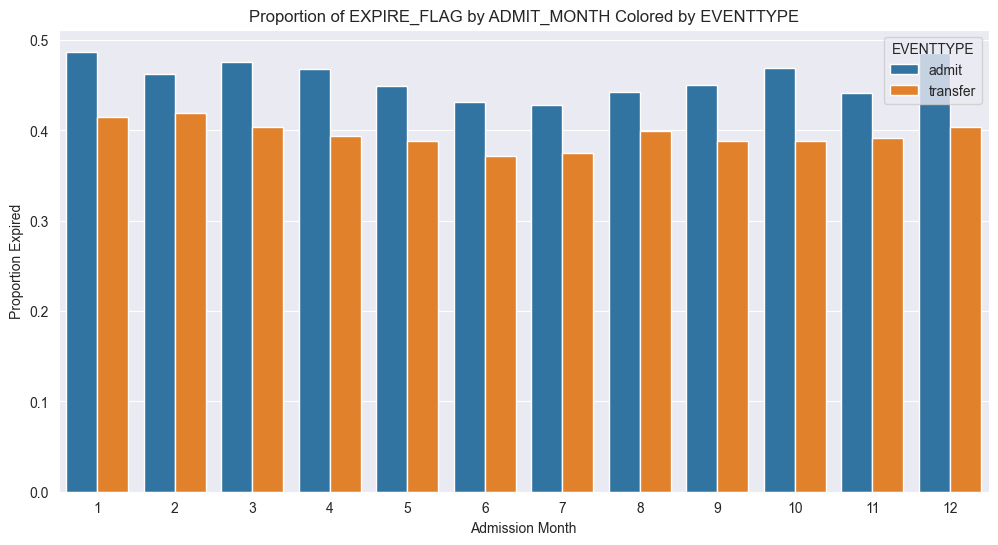

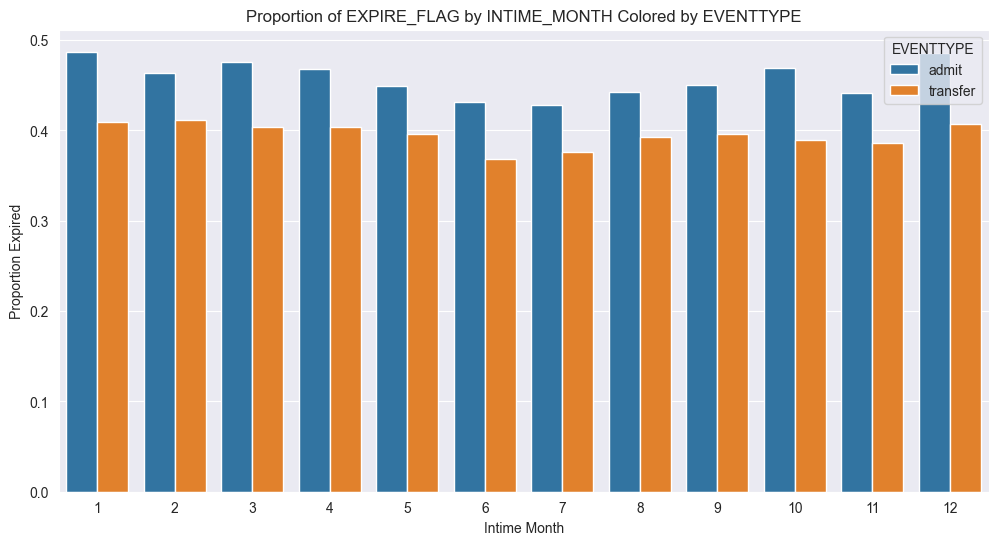

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot for ADMIT_MONTH
plt.figure(figsize=(12, 6))
sns.barplot(x='ADMIT_MONTH', y='EXPIRE_FLAG', hue='EVENTTYPE', data=admit_month_proportions)
plt.title('Proportion of EXPIRE_FLAG by ADMIT_MONTH Colored by EVENTTYPE')
plt.xlabel('Admission Month')
plt.ylabel('Proportion Expired')
plt.show()

# Plot for INTIME_MONTH
plt.figure(figsize=(12, 6))
sns.barplot(x='INTIME_MONTH', y='EXPIRE_FLAG', hue='EVENTTYPE', data=intime_month_proportions)
plt.title('Proportion of EXPIRE_FLAG by INTIME_MONTH Colored by EVENTTYPE')
plt.xlabel('Intime Month')
plt.ylabel('Proportion Expired')
plt.show()


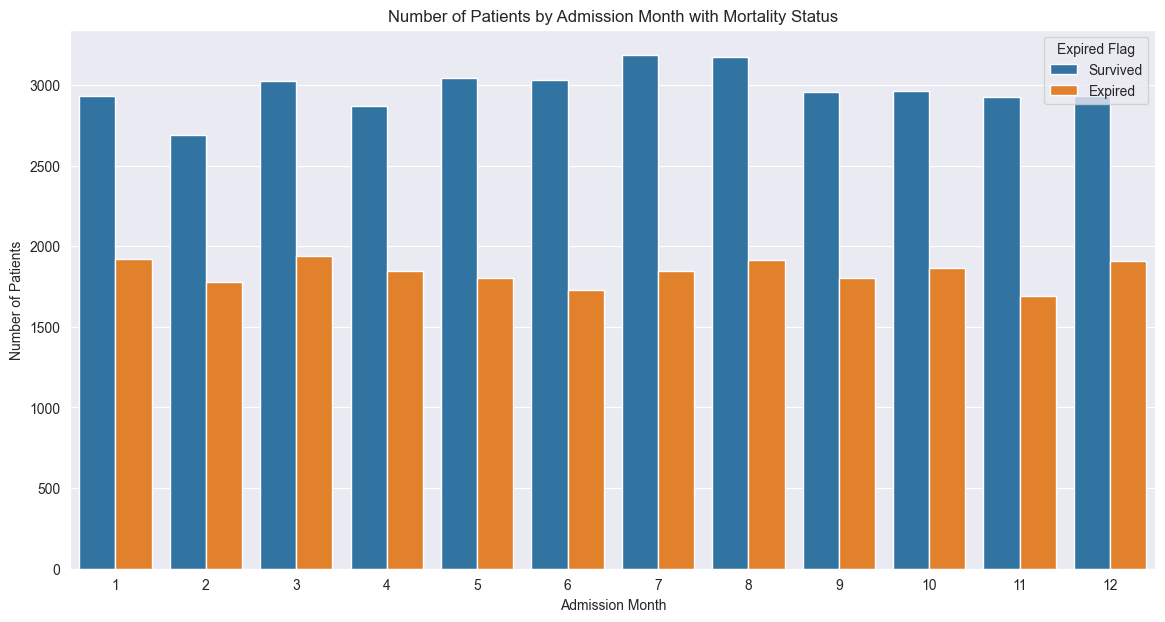

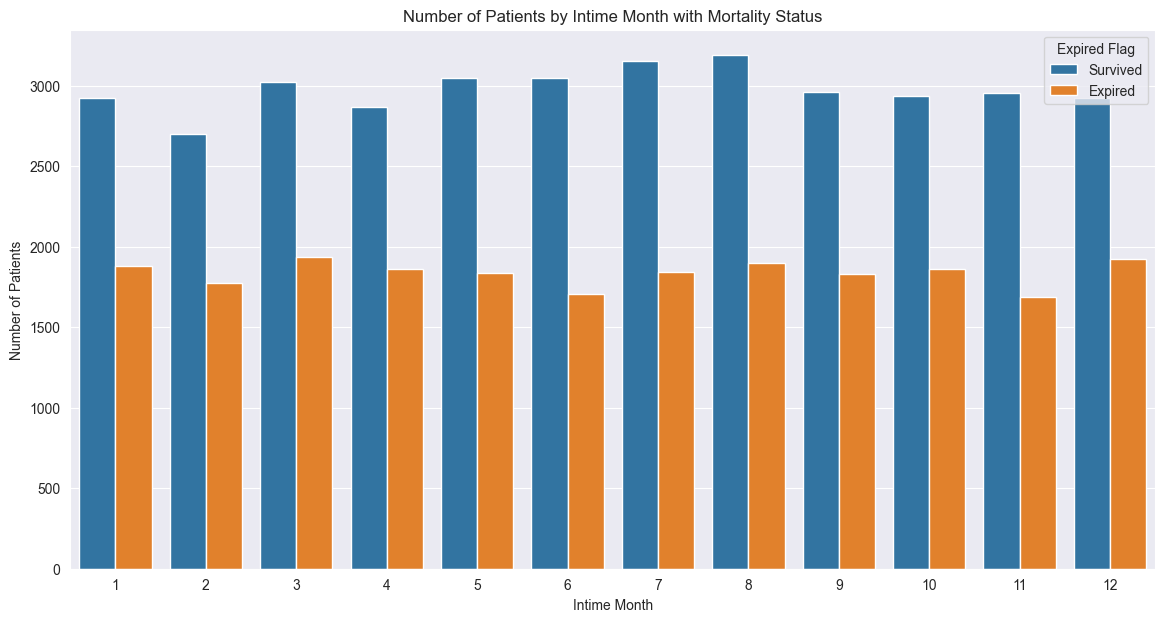

In [172]:
# Example of aggregating ICU stays at the admission level
admission_level_data2 = df_cleaned.groupby(['SUBJECT_ID', 'HADM_ID']).agg({
    'EXPIRE_FLAG': 'max',  # Assuming 1 if patient died at any point during the admission
    'LOS_ICU': 'sum',  # Summing up ICU stay lengths for each admission
    'INTIME_MONTH': 'last',  # Assuming the month of the first ICU stay applies to the whole admission
    'ADMIT_MONTH': 'first',  # Assuming the month of the first ICU stay applies to the whole admission
}).reset_index()

# Plotting
plt.figure(figsize=(14, 7))

# Count plot for ADMIT_MONTH with hue based on EXPIRE_FLAG
sns.countplot(data=admission_level_data2, x='ADMIT_MONTH', hue='EXPIRE_FLAG')
plt.title('Number of Patients by Admission Month with Mortality Status')
plt.xlabel('Admission Month')
plt.ylabel('Number of Patients')
plt.legend(title='Expired Flag', labels=['Survived', 'Expired'])
plt.show()

# Count plot for INTIME_MONTH with hue based on EXPIRE_FLAG
plt.figure(figsize=(14, 7))
sns.countplot(data=admission_level_data2, x='INTIME_MONTH', hue='EXPIRE_FLAG')
plt.title('Number of Patients by Intime Month with Mortality Status')
plt.xlabel('Intime Month')
plt.ylabel('Number of Patients')
plt.legend(title='Expired Flag', labels=['Survived', 'Expired'])
plt.show()

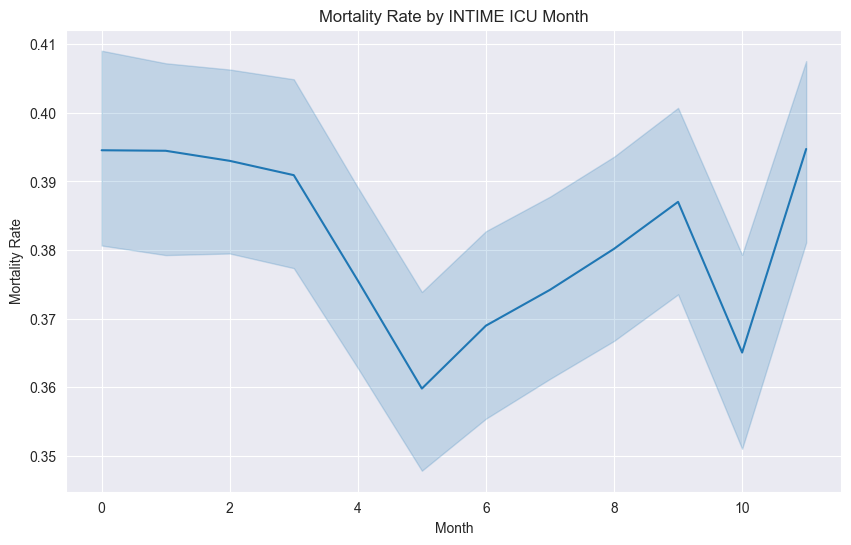

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example of aggregating ICU stays at the admission level
admission_level_data = df_cleaned.groupby(['SUBJECT_ID', 'HADM_ID']).agg({
    'EXPIRE_FLAG': 'max',  # Assuming 1 if patient died at any point during the admission
    'LOS_ICU': 'sum',  # Summing up ICU stay lengths for each admission
    'INTIME_MONTH': 'first',  # month of the first ICU stay applies to the whole admission
     'ADMIT_MONTH': 'first',  
    # Add other aggregations as needed
}).reset_index()
# 
# mortality_by_month = admission_level_data.groupby('ADMIT_MONTH')['EXPIRE_FLAG'].mean().reset_index()
# Assuming 'admission_level_data' is your DataFrame
admission_level_data['INTIME_MONTH'] = admission_level_data['INTIME_MONTH'].astype('category').cat.codes
admission_level_data['ADMIT_MONTH'] = admission_level_data['ADMIT_MONTH'].astype('category').cat.codes

# Check for any non-numeric columns
admission_level_data = admission_level_data.select_dtypes(include=[np.number])
# Plot the mortality rate by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=admission_level_data, x='INTIME_MONTH', y='EXPIRE_FLAG')
plt.title('Mortality Rate by INTIME ICU Month')
plt.xlabel('Month')
plt.ylabel('Mortality Rate')
plt.show()

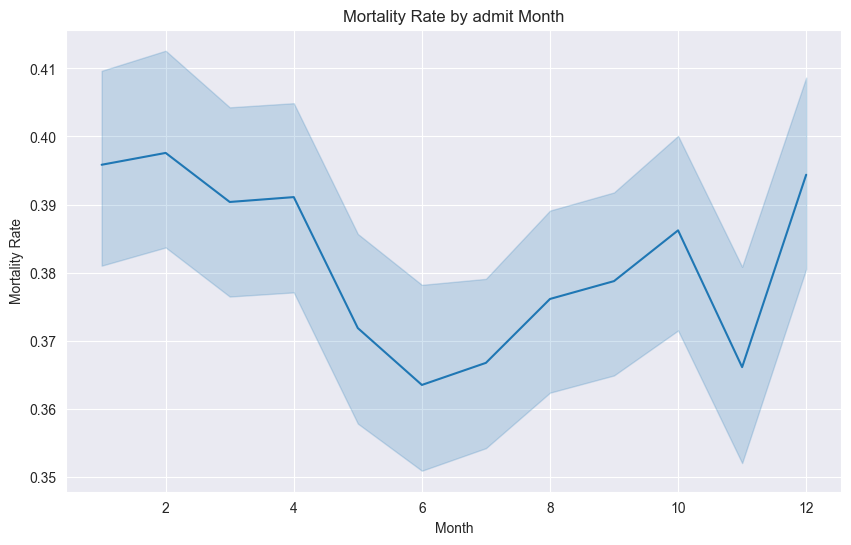

In [151]:
# Plot the mortality rate by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=admission_level_data, x='ADMIT_MONTH', y='EXPIRE_FLAG')
plt.title('Mortality Rate by admit Month')
plt.xlabel('Month')
plt.ylabel('Mortality Rate')
plt.show()

In [159]:
# For statistical significance, we can perform a chi-square test if the data meets the assumptions
# Prepare the contingency table
contingency_table = pd.crosstab(admission_level_data['INTIME_MONTH'], admission_level_data['EXPIRE_FLAG'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 35.4801542260928, p-value: 0.0002064201453947517


In [160]:
# For statistical significance, we can perform a chi-square test if the data meets the assumptions
# Prepare the contingency table
contingency_table = pd.crosstab(admission_level_data['ADMIT_MONTH'], admission_level_data['EXPIRE_FLAG'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

Chi-Square Statistic: 34.97248993995931, p-value: 0.00025040348554425894


In [165]:
X = admission_level_data.drop('EXPIRE_FLAG', axis=1)
y = admission_level_data['EXPIRE_FLAG']

X = sm.add_constant(X)  # adds a constant term to the predictor

In [166]:
model = sm.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.659389
         Iterations 4


In [167]:
print(result.summary())


                           Logit Regression Results                           
Dep. Variable:            EXPIRE_FLAG   No. Observations:                57775
Model:                          Logit   Df Residuals:                    57769
Method:                           MLE   Df Model:                            5
Date:                Tue, 27 Feb 2024   Pseudo R-squ.:                0.008103
Time:                        13:24:50   Log-Likelihood:                -38096.
converged:                       True   LL-Null:                       -38407.
Covariance Type:            nonrobust   LLR p-value:                2.849e-132
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1992      0.049     -4.083      0.000      -0.295      -0.104
SUBJECT_ID   -7.609e-06   3.17e-07    -23.988      0.000   -8.23e-06   -6.99e-06
HADM_ID      -1.139e-07   2.98e-07     -0.38

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X = admission_level_data.drop('EXPIRE_FLAG', axis=1)
y = admission_level_data['EXPIRE_FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [163]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

AUC Score: 0.5608218470273698
              precision    recall  f1-score   support

           0       0.61      1.00      0.76      7061
           1       0.00      0.00      0.00      4494

    accuracy                           0.61     11555
   macro avg       0.31      0.50      0.38     11555
weighted avg       0.37      0.61      0.46     11555


/Users/ninad/Projects/pythonProject1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ninad/Projects/pythonProject1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ninad/Projects/pythonProject1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [164]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
feature_importance.sort_values(by='Coefficient', ascending=False, inplace=True)
print(feature_importance)


        Feature   Coefficient
2       LOS_ICU  6.923270e-10
3  INTIME_MONTH -4.005377e-10
4   ADMIT_MONTH -4.038836e-10
1       HADM_ID -1.437340e-06
0    SUBJECT_ID -8.113888e-06
